In [1]:
import shapely
from shapely import wkt
from shapely import (
    Point, 
    MultiPoint, 
    Polygon, 
    MultiPolygon, 
    LineString, 
    MultiLineString,
    GeometryCollection
)
slab_edge_file = 'slab_edge.wkt.txt'
slab_openings_file = 'slab_openings.wkt.txt'
walls_file = 'walls.wkt.txt'
columns_file = 'columns.wkt.txt'
load_heavy_file = 'load_heavy.wkt.txt'
load_light_file = 'load_light.wkt.txt'

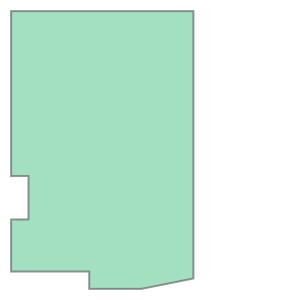

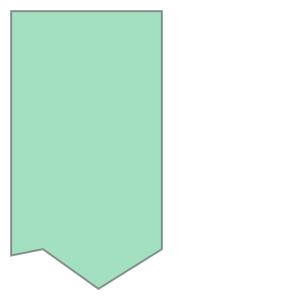

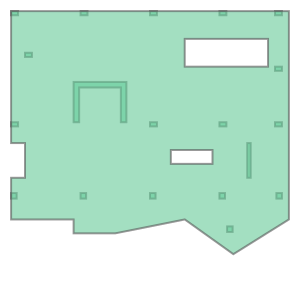

In [26]:

with open(slab_edge_file, 'r') as file:
    slab_outline = wkt.load(file)
with open(slab_openings_file, 'r') as file:
    slab_openings = wkt.load(file)
with open(columns_file, 'r') as file:
    columns = wkt.load(file)
with open(walls_file, 'r') as file:
    walls = wkt.load(file)

with open(load_heavy_file, 'r') as file:
    load_heavy = wkt.load(file)

with open(load_light_file, 'r') as file:
    load_light = wkt.load(file)

#slab = Polygon(shell = slab_outline.exterior.coords, holes = slab_openings.geoms)
slab = Polygon(
    shell = slab_outline.exterior.coords,
    holes = [opening.exterior.coords for opening in slab_openings.geoms]
)
display(load_light)
display(load_heavy)
GeometryCollection([columns,walls,slab])

In [27]:
list(walls.geoms)

[<POLYGON ((8300 7000, 8300 9900, 4500 9900, 4500 7000, 4900 7000, 4900 9500,...>,
 <POLYGON ((17000 3000, 17250 3000, 17250 5500, 17000 5500, 17000 3000))>]

## Start
The key to this procedure is that I need to identify which point is a part of which polygon after the voronoi regions are calculated because the order of the points and voronoi regions is going to become scrambled.

So, I will make the assumption that each point can only be a part of one polygon and then make a dictionary that allows me to look up points by their polygon so that I can group them after the voronoi procedure. Using this look-up tool, I will be able to create a second look-up dictionary based on trib areas keyed by polygons. Combining both lookups will allow me to correlate all the trib regions with their original generating polygons.

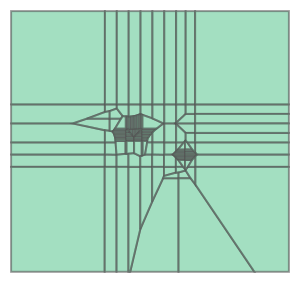

In [28]:
import more_itertools # This library is included in PfSE. Look it up on PyPI for docs (useful)

# Make sure the first/last point is not duplicated in the list
column_points = [list(column.exterior.coords)[:-1] for column in columns.geoms]

# Break up wall in to smaller segments according to a maximum segment length
max_seg_length = 300

segmented_walls = [
    Polygon(shapely.segmentize(wall.exterior, max_seg_length))
    for wall in walls.geoms
]
wall_points = [list(wall.exterior.coords)[:-1] for wall in segmented_walls]

grouped_points = column_points + wall_points
flattened_points = list(more_itertools.flatten(grouped_points))
voronoi_source = MultiPoint(flattened_points)
v_polys = shapely.voronoi_polygons(voronoi_source)
v_polys

## Get the clipped voronoi regions

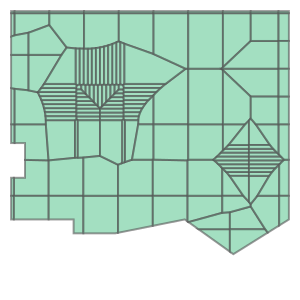

In [30]:
# this is option to include the openings
trib_components_wo_openings = [slab_outline & v_poly for v_poly in v_polys.geoms]
GeometryCollection(trib_components_wo_openings)

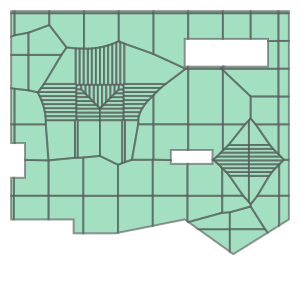

In [25]:
trib_components = [slab & v_poly for v_poly in v_polys.geoms]
GeometryCollection(trib_components)

## Reorder trib components to match order of source points

In [15]:
reordered_components = []
for point in flattened_points: # Iterate by points to prioritize point order
    for poly in trib_components:
        if poly.contains(Point(point)) or poly.touches(Point(point)):
            reordered_components.append(poly)

In [16]:
len(reordered_components)

153

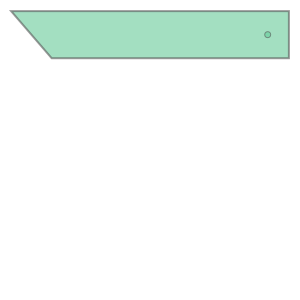

In [17]:
idx = 152
display(GeometryCollection([reordered_components[idx], Point(flattened_points[idx])]))

## Group trib components by their source geometry

Using a `dict` where the keys are points (`tuple`) and the values are Polygons can be efficient to find which points are in which polygons and, thus, should be grouped with the neighbouring trib components.

### Create the point-polygon lookup

In [18]:
all_polygons = list(columns.geoms) + segmented_walls

poly_lookup = {}
for idx, point_group in enumerate(grouped_points):
    for point in point_group:
        poly_lookup.update({point: all_polygons[idx]})

### Create the polygon-trib component lookup

In [19]:
trib_lookup = {}
for idx, trib_component in enumerate(reordered_components):
    corresponding_point = flattened_points[idx]
    corresponding_polygon = poly_lookup[corresponding_point]
    trib_component_list = trib_lookup.get(corresponding_polygon, [])
    trib_component_list.append(trib_component)
    trib_lookup[corresponding_polygon] = trib_component_list

### Perform a union on all trib components corresponding to each input geometry

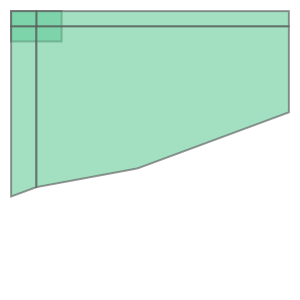

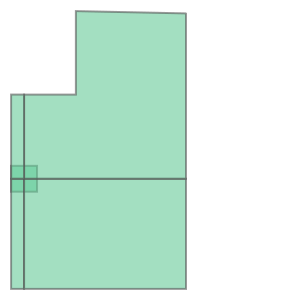

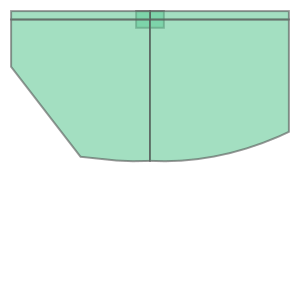

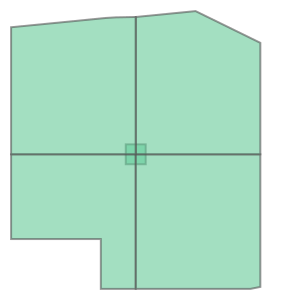

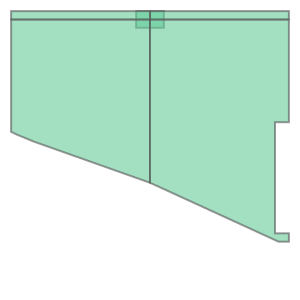

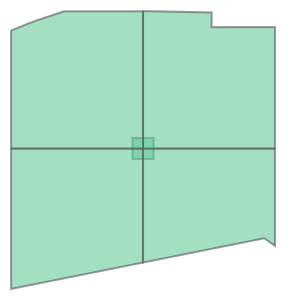

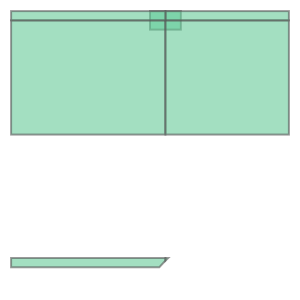

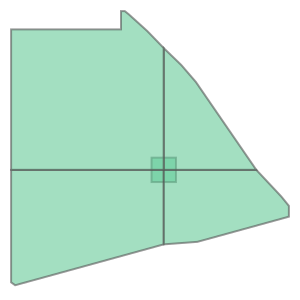

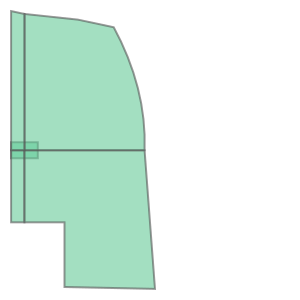

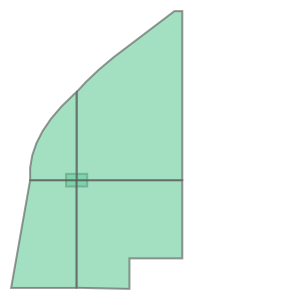

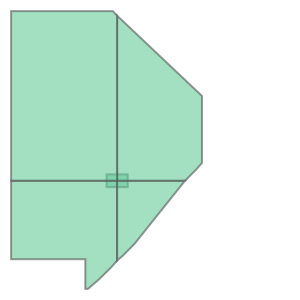

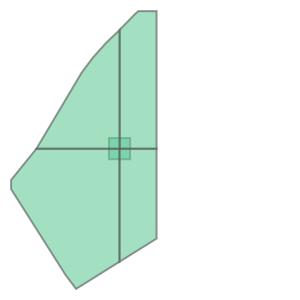

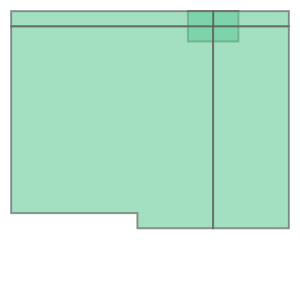

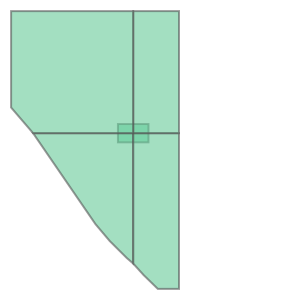

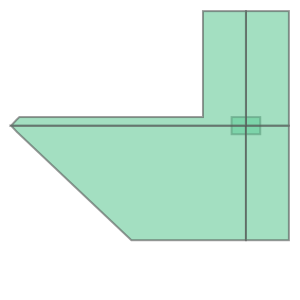

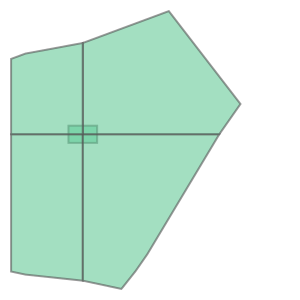

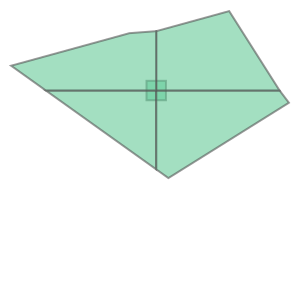

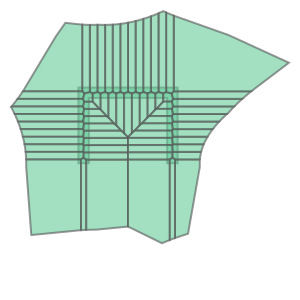

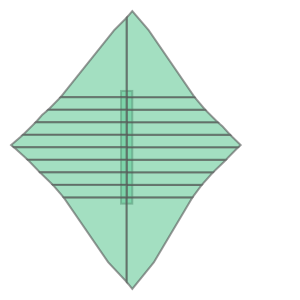

In [22]:
trib_area_lookup = {}
for polygon, trib_components in trib_lookup.items():
    trib_area_lookup[polygon] = shapely.unary_union(trib_components)
    display(GeometryCollection([polygon, *trib_components]))

## View Results

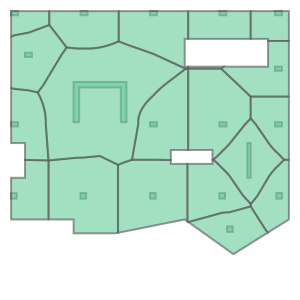

In [21]:
trib_areas = trib_area_lookup.values()
source_geometry = trib_area_lookup.keys()
GeometryCollection([*source_geometry, *trib_areas])